# Debugging the Pipline

in this notebook we want to get our pipeline up and running and test the key components




In [4]:
%load_ext autoreload
%autoreload 2
%cd ~/GitRepos/activeCell-ACDC

#import sys
#sys.path.append("..")

import json
import random as rd
import matplotlib.image as mpimg
import tqdm
from matplotlib import cm

import cv2
import wandb
import torch
import os
import numpy as np

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.test import do_test
from src.train import do_train
from src.predict import predict_image_in_acdc
from src.config_builder import get_config



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC


In [5]:
DATASET = ACDC_LAST_IMAGES
CONFIG_NAME = "acdc_small_full_ds"

In [21]:
register_datasets()
#dataset_json_train = DatasetCatalog.get(get_dataset_name(DATASET,TRAIN))
dataset_json_test = DatasetCatalog.get(get_dataset_name(DATASET,TEST))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset
registering acdc_last_images dataset


In [47]:
def plot_ground_truth(image_json, dataset=DATASET, data_type=TEST):

    in_image = cv2.imread(image_json["file_name"])
    visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    out_image = out.get_image()[:, :, ::-1]
    #show_image([in_image,out_image])
    show_image([in_image,out_image])

def plot_prediction(image_json, config_name=CONFIG_NAME):

    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    im = cv2.imread(image_json["file_name"])
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    show_image([im,out.get_image()[:, :, ::-1]])

def plot_trio(image_json, dataset=DATASET, data_type=TEST, config_name=CONFIG_NAME):
    
    # ground truth
    raw_im = cv2.imread(image_json["file_name"])

    visualizer = Visualizer(raw_im[:, :, ::-1], metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    ground_truth_im = out.get_image()[:, :, ::-1]
    
    # prediction
    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    outputs = predictor(raw_im)
    
    v = Visualizer(raw_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


    predicted_instances = np.asarray(outputs["instances"].pred_masks.to("cpu"))
    predicted_mask = np.zeros(predicted_instances[0].shape)

    for id in range(len(predicted_instances)):
        np.place(predicted_mask, predicted_instances[id], 1)

    predicted_im = out.get_image()[:, :, ::-1]


    visualizer = Visualizer(np.zeros(raw_im[:, :, ::-1].shape), metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    new_im_json = image_json.copy()
    new_im_json["annotations"] = []
    for anno in image_json["annotations"]:
        new_anno = anno.copy()
        new_anno["bbox"] = [0,0,0,0]
        new_im_json["annotations"].append(new_anno)
    out = visualizer.draw_dataset_dict(new_im_json)
    print(np.array(out.get_image()[:, :, ::-1]).shape)
    ground_truth_mask = (np.array(out.get_image()[:, :, ::-1]) != 0).max(axis=2).astype(np.uint8)
    ground_truth_mask = cv2.resize(ground_truth_mask*255, dsize=(predicted_mask.shape[1],predicted_mask.shape[0]), interpolation=cv2.INTER_CUBIC)


    print("############################################################################")
    print(image_json["file_name"])

    show_image([raw_im, ground_truth_im,predicted_im, ground_truth_mask, predicted_mask, (ground_truth_mask > 0) - predicted_mask])
    

## SHOW IMAGES AND GROUND TRUTHS

############################################################################
./data/acdc_last_images/test/images/acdc_data3_20211029_pos_1_200.png


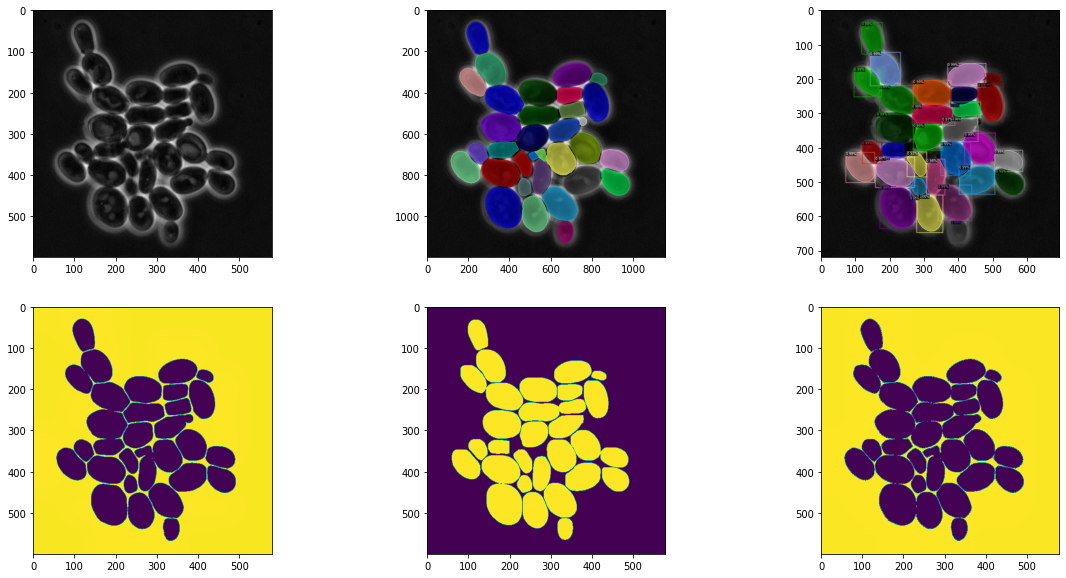

In [17]:
rd.seed(1337)
for ds_json in rd.sample(dataset_json_test, 1):
    plot_trio(ds_json)

In [9]:
def evaluate(config_name=CONFIG_NAME, dataset=DATASET, data_type=TEST):

    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)


    evaluator = COCOEvaluator(get_dataset_name(dataset,data_type), output_dir=cfg.OUTPUT_DIR)
    data_loader = build_detection_test_loader(cfg, get_dataset_name(dataset,data_type))
    evaluator = COCOEvaluator(get_dataset_name(dataset,data_type), output_dir=cfg.OUTPUT_DIR)
    results_i = inference_on_dataset(predictor.model, data_loader, evaluator)
    # %%capture
    result_dict = {}
    ds_json = DatasetCatalog.get(get_dataset_name(dataset,data_type))
    for image in ds_json:
        result = evaluator.evaluate(image["image_id"])
        result_dict[image["file_name"]] = result

    with open(os.path.join(cfg.OUTPUT_DIR, "aps.txt"), "w") as file:
        file.write(str(result_dict))

    return result_dict

result_dict = evaluate()


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.843
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.685
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



DONE (t=2.69s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.904
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

In [10]:
import pandas as pd

segm_aps = []
bbox_aps = []
image_names = []

for key in result_dict.keys():
    image_names.append(key)
    segm_aps.append(result_dict[key]["segm"]["AP"])
    bbox_aps.append(result_dict[key]["bbox"]["AP"])

df = pd.DataFrame(data={"image_name": image_names, "segm_ap": segm_aps, "bbox_ap": bbox_aps})


(1074, 1206, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_Yagya_SCGE_WT_pos_2_279.png


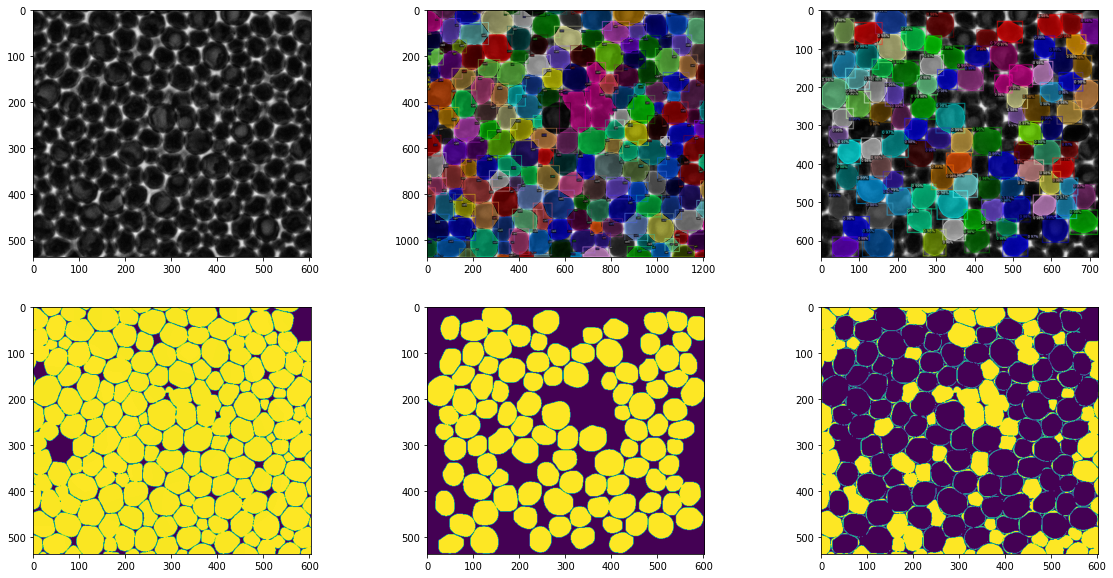

(970, 1224, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_Yagya_SCGE_WT_pos_5_289.png


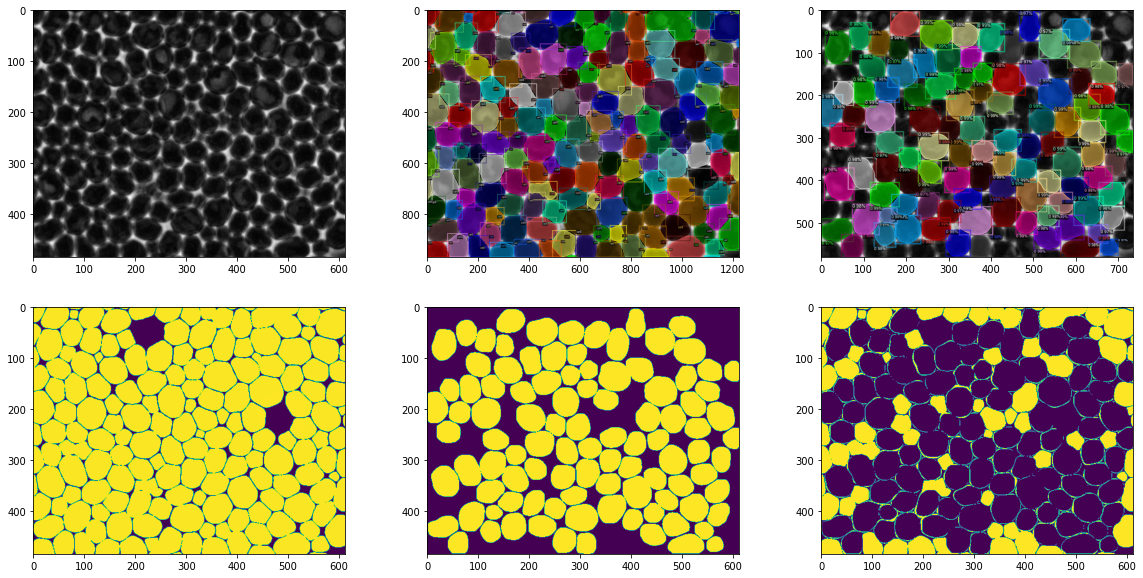

(1008, 1144, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_Yagya_SCGE_WT_pos_7_254.png


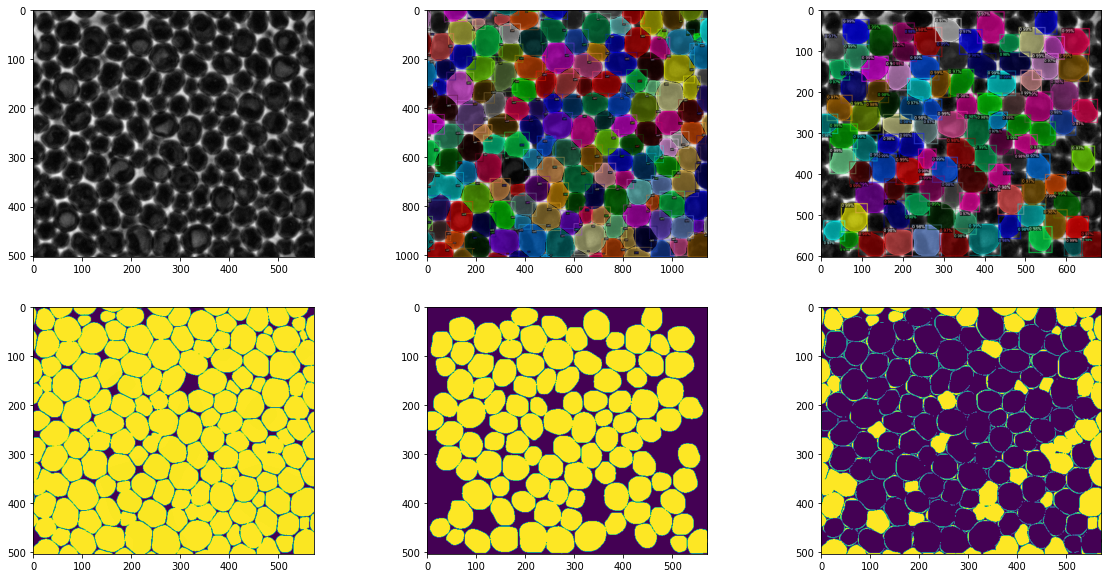

(2048, 2048, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data2_kurt_306-3_20_20201105_pos_3_200.png


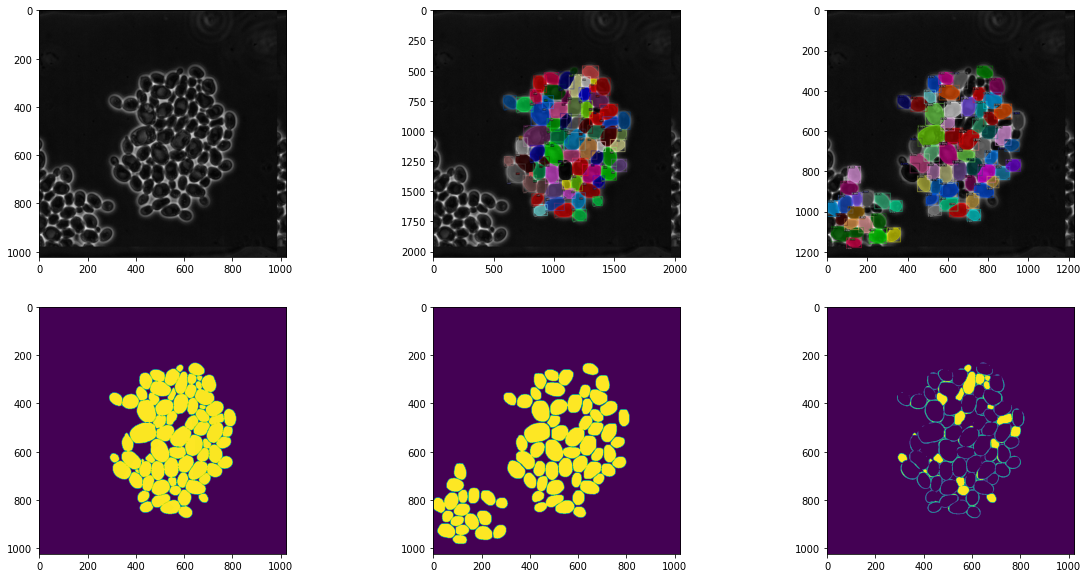

(2048, 1682, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_20210722_pos_5_200.png


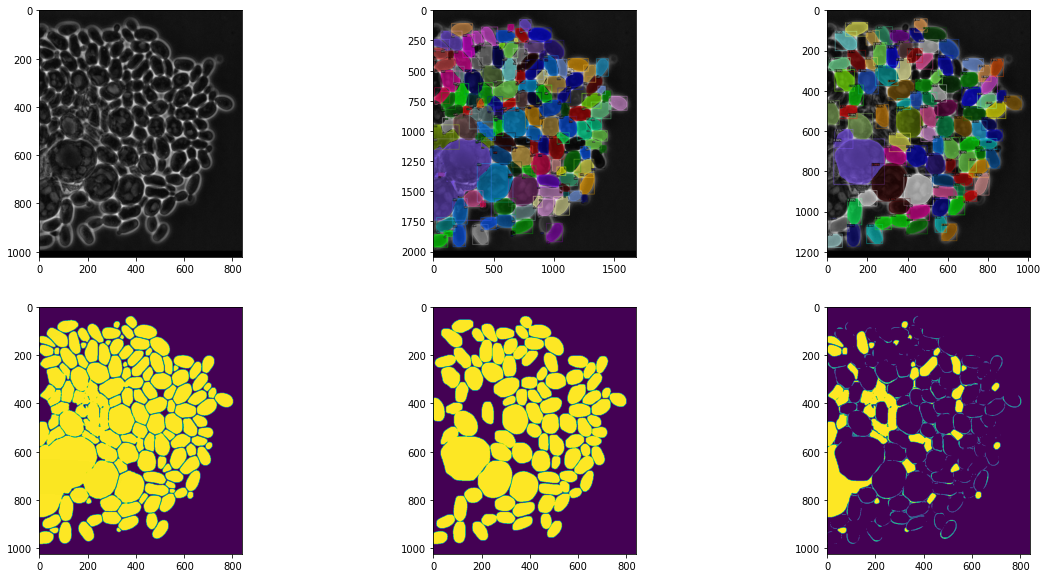

(958, 1106, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_Yagya_SCGE_WT_pos_1_320.png


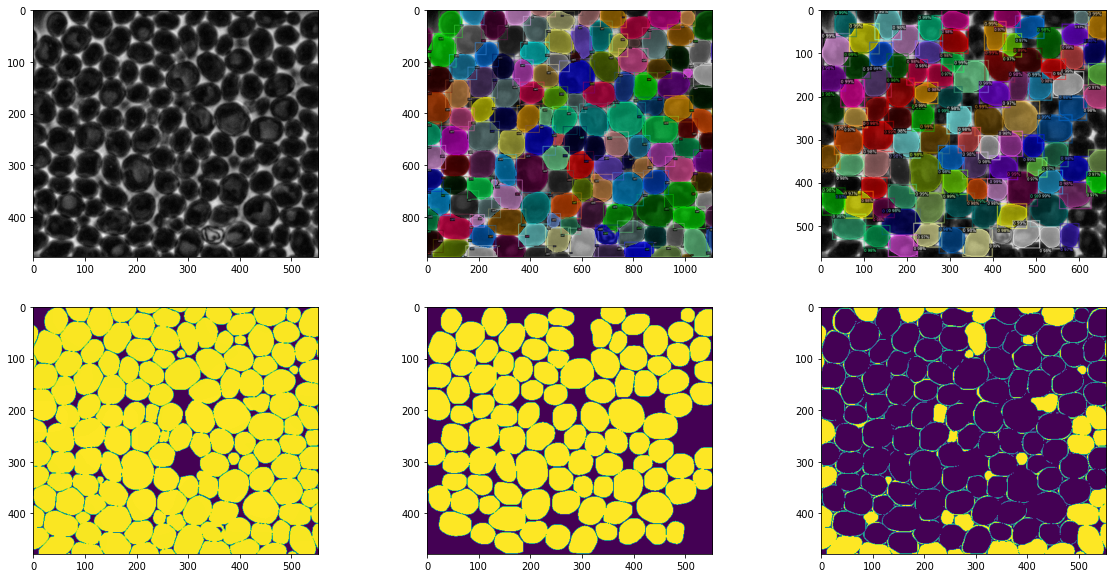

(1600, 2048, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_20210722_pos_2_200.png


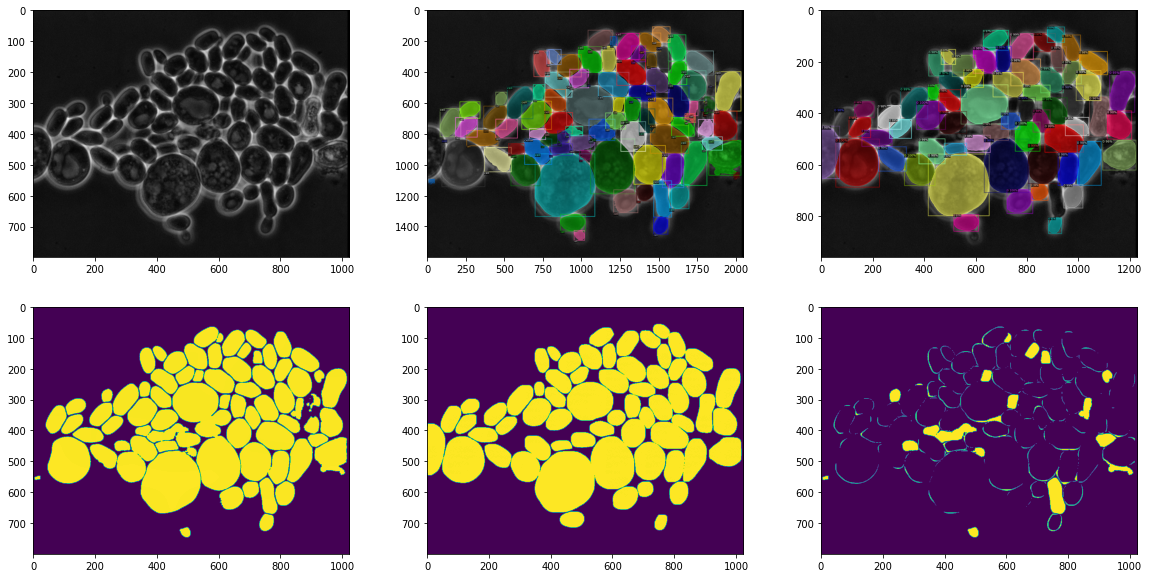

(2048, 2048, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data2_kurt_306-3_20_20201105_pos_5_200.png


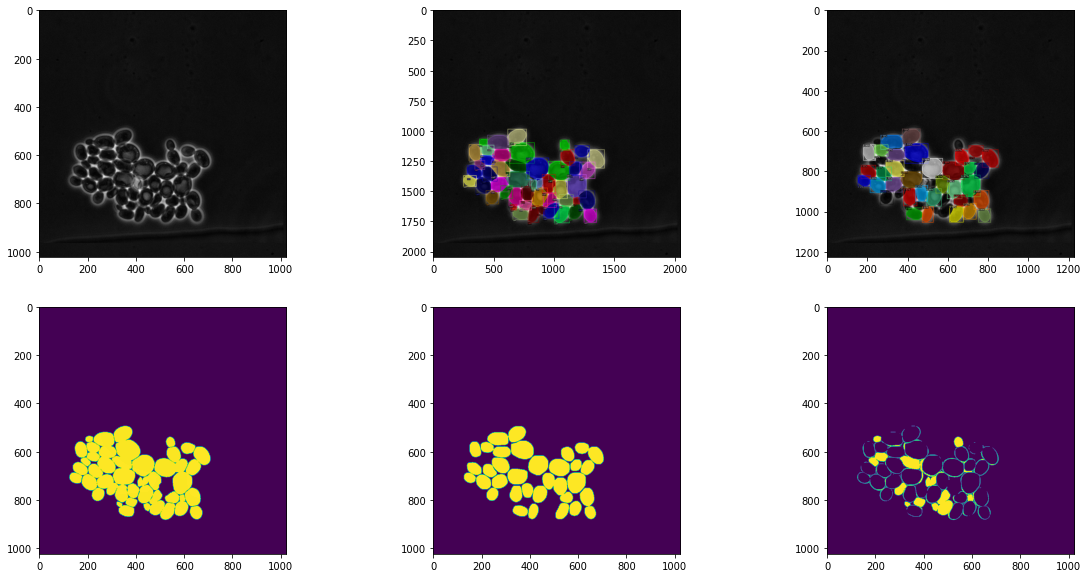

(858, 1084, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_Yagya_SCGE_WT_pos_3_224.png


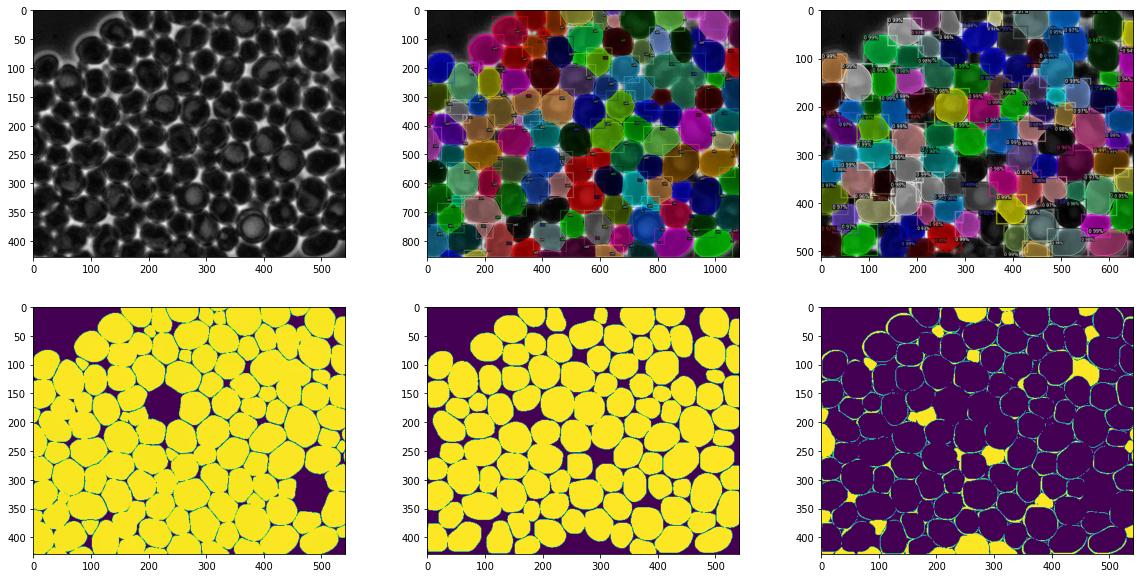

(930, 1054, 3)
############################################################################
./data/acdc_last_images/test/images/acdc_data3_Yagya_SCGE_WT_pos_4_229.png


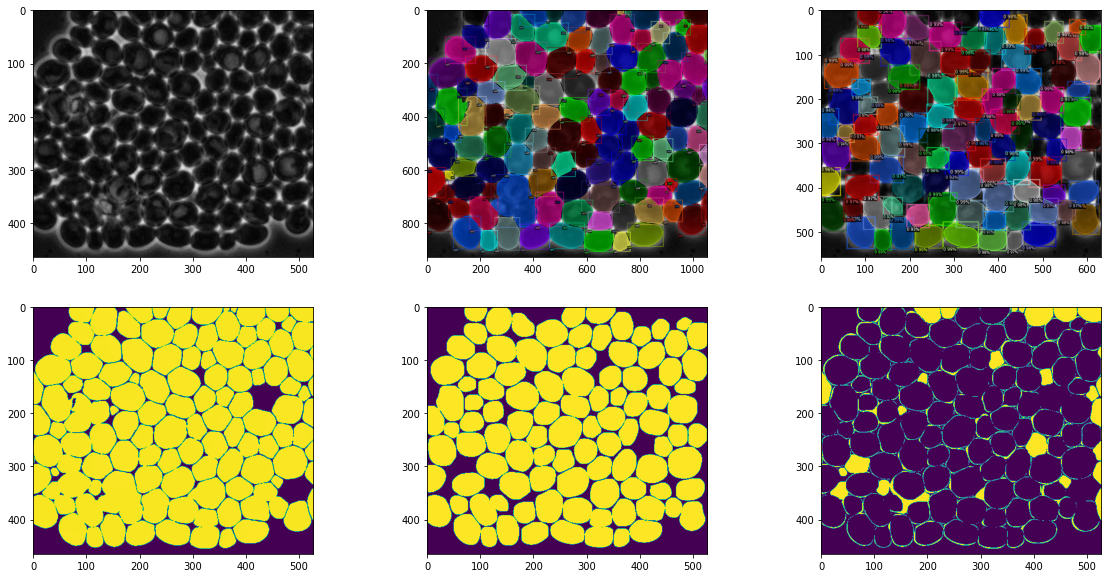

In [59]:
for index, row in df.sort_values(by=["segm_ap", "bbox_ap"]).head(10).iterrows():
    plot_trio(dataset_json_test[index])
#df.sort_values(by=["segm_ap", "bbox_ap"]).head(20)
#plot_trio(dataset_json_test[11])